In [2]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('CEV2021.csv')

In [3]:
from ISLP import load_data
OJ = load_data('OJ')

In [4]:
# Training set: StoreID 1–4
Train = OJ[OJ['StoreID'].isin([1, 2, 3, 4])].copy()

# Test set: StoreID 7
Test = OJ[OJ['StoreID'] == 7].copy()


In [5]:
Train.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.50,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.60,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.68,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.40,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
16,MM,240,1,1.75,1.99,0.00,0.3,0,1,0.50,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1


In [6]:
train_sub = Train[['LoyalCH', 'DiscCH', 'PriceDiff']]

print(train_sub.agg(['mean', 'median', 'std', 'min', 'max']))

         LoyalCH    DiscCH  PriceDiff
mean    0.519988  0.023768   0.114524
median  0.500000  0.000000   0.200000
std     0.313757  0.057962   0.255935
min     0.000011  0.000000  -0.670000
max     0.999947  0.300000   0.440000


In [7]:

correl_matrix = train_sub.corr()
print(correl_matrix)

            LoyalCH    DiscCH  PriceDiff
LoyalCH    1.000000  0.032394   0.008349
DiscCH     0.032394  1.000000   0.051662
PriceDiff  0.008349  0.051662   1.000000


In [8]:
import statsmodels.api as sm
y = (Train['Purchase'] == 'CH').astype(int)
train_sub = sm.add_constant(train_sub)

logreg = sm.Logit(y,train_sub)
result = logreg.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.413892
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                  714
Model:                          Logit   Df Residuals:                      710
Method:                           MLE   Df Model:                            3
Date:                Wed, 22 Oct 2025   Pseudo R-squ.:                  0.4012
Time:                        22:28:09   Log-Likelihood:                -295.52
converged:                       True   LL-Null:                       -493.55
Covariance Type:            nonrobust   LLR p-value:                 1.577e-85
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4445      0.270    -12.755      0.000      -3.974      -2.915
LoyalCH        6.3846      0.

In [9]:
# Predicted probabilities (for Purchase = CH)
y_pred_prob = result.predict(train_sub)

# Classify as CH (1) if prob ≥ 0.5, else MM (0)
y_pred = (y_pred_prob >= 0.5).astype(int)


In [10]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred)
print(cm)


[[269  66]
 [ 61 318]]


In [11]:
# Predicted probabilities (for Purchase = CH)
train_sub_sig = Train[['LoyalCH', 'PriceDiff']]
train_sub_sig = sm.add_constant(train_sub_sig)

logreg = sm.Logit(y,train_sub_sig)
result1 = logreg.fit()

print(result1.summary())

y_pred_prob1 = result1.predict(train_sub_sig)

# Classify as CH (1) if prob ≥ 0.5, else MM (0)
y_pred1 = (y_pred_prob1 >= 0.5).astype(int)
cm1 = confusion_matrix(y, y_pred1)
print(cm1)

Optimization terminated successfully.
         Current function value: 0.414274
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                  714
Model:                          Logit   Df Residuals:                      711
Method:                           MLE   Df Model:                            2
Date:                Wed, 22 Oct 2025   Pseudo R-squ.:                  0.4007
Time:                        22:28:09   Log-Likelihood:                -295.79
converged:                       True   LL-Null:                       -493.55
Covariance Type:            nonrobust   LLR p-value:                 1.301e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4159      0.266    -12.820      0.000      -3.938      -2.894
LoyalCH        6.3811      0.

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Significant predictors from part (e)
predictors = ['LoyalCH', 'PriceDiff']

# Prepare data
y_train = (Train['Purchase'] == 'CH').astype(int)
y_test = (Test['Purchase'] == 'CH').astype(int)
X_train_raw = Train[predictors]
X_test_raw = Test[predictors]

# Standardize predictors
scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Fit Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predictions on Test set
y_pred_prob_nb = nb.predict_proba(X_test)[:, 1]
y_pred_nb = (y_pred_prob_nb >= 0.5).astype(int)

# Confusion matrix and metrics
print(confusion_matrix(y_test, y_pred_nb))



[[ 64  18]
 [ 39 235]]


In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Train kNN models for k = 5, 50, 150
ks = [5, 50, 150]
knn_models = {}
knn_probs = {}

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_models[k] = knn
    knn_probs[k] = knn.predict_proba(X_test)[:, 1]

# Evaluate k = 50 model
k = 50
y_pred_knn = (knn_probs[k] >= 0.5).astype(int)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred_knn).ravel()
accuracy = (TP + TN) / (TP + TN + FP + FN)
false_pos = FP / (FP + TN)
false_neg = FN / (FN + TP)

print(f"=== k-NN (k={k}) (Test) ===")
print(f"Confusion matrix:\n[[{TN}, {FP}],\n [{FN}, {TP}]]")
print(f"Accuracy: {accuracy:.3f}")
print(f"False positive rate: {false_pos:.3%}")
print(f"False negative rate: {false_neg:.3%}")


=== k-NN (k=50) (Test) ===
Confusion matrix:
[[60, 22],
 [38, 236]]
Accuracy: 0.831
False positive rate: 26.829%
False negative rate: 13.869%


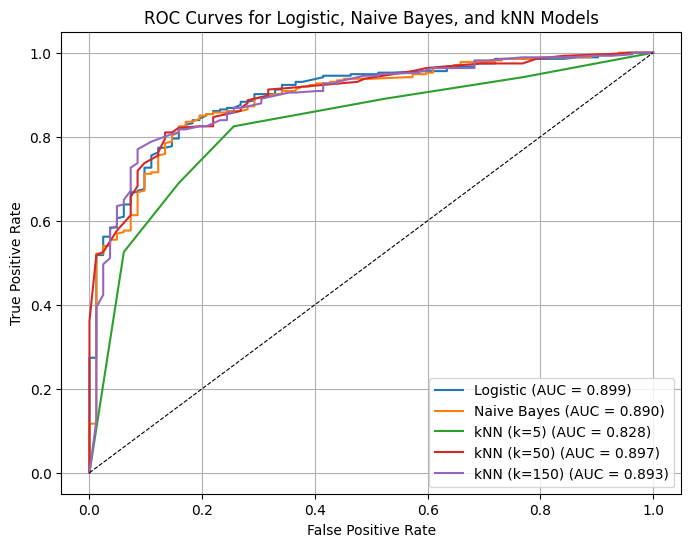

=== AUC Scores ===
Logistic: 0.8985
kNN (k=50): 0.8972
kNN (k=150): 0.8934
Naive Bayes: 0.8903
kNN (k=5): 0.8277

Highest AUC: Logistic (0.8985)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Fit logistic regression on Train (same predictors)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
y_pred_prob_log = logreg.predict_proba(X_test)[:, 1]

# Compute ROC curves and AUCs for all models
models = {
    'Logistic': y_pred_prob_log,
    'Naive Bayes': y_pred_prob_nb,
    'kNN (k=5)': knn_probs[5],
    'kNN (k=50)': knn_probs[50],
    'kNN (k=150)': knn_probs[150]
}

plt.figure(figsize=(8,6))
aucs = {}

for name, probs in models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    aucs[name] = roc_auc
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# Diagonal reference line
plt.plot([0,1],[0,1],'k--',lw=0.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Logistic, Naive Bayes, and kNN Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Display AUC rankings
print("=== AUC Scores ===")
for name, val in sorted(aucs.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {val:.4f}")

best_model = max(aucs, key=aucs.get)
print(f"\nHighest AUC: {best_model} ({aucs[best_model]:.4f})")


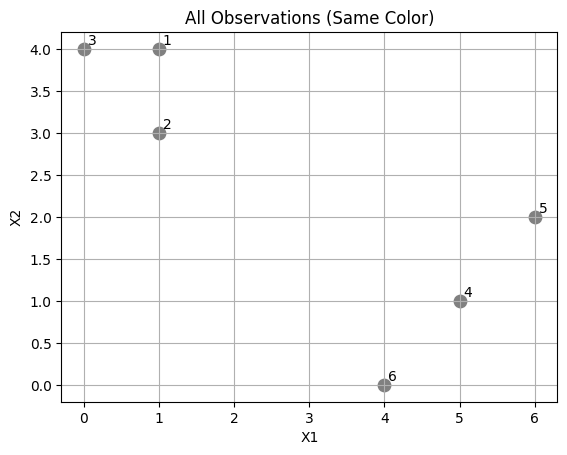

In [15]:
import numpy as np
# Data (X1, X2)
X = np.array([
    [1, 4],
    [1, 3],
    [0, 4],
    [5, 1],
    [6, 2],
    [4, 0]
])

plt.scatter(X[:, 0], X[:, 1], color='gray', s=80)
for i, (x1, x2) in enumerate(X, start=1):
    plt.text(x1 + 0.05, x2 + 0.05, str(i))
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("All Observations (Same Color)")
plt.grid(True)
plt.show()


In [16]:
np.random.seed(42)
K = 2
labels = np.random.choice([0, 1], size=len(X))

print("Initial Random Cluster Labels:")
for i, lbl in enumerate(labels, start=1):
    print(f"Observation {i}: Cluster {lbl}")


Initial Random Cluster Labels:
Observation 1: Cluster 0
Observation 2: Cluster 1
Observation 3: Cluster 0
Observation 4: Cluster 0
Observation 5: Cluster 0
Observation 6: Cluster 1


In [17]:
def compute_centroids(X, labels, K):
    centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])
    return centroids

centroids = compute_centroids(X, labels, K)
print("Initial Centroids:\n", centroids)


Initial Centroids:
 [[3.   2.75]
 [2.5  1.5 ]]


In [18]:
from scipy.spatial.distance import cdist

def assign_clusters(X, centroids):
    distances = cdist(X, centroids, 'euclidean')
    return np.argmin(distances, axis=1)

new_labels = assign_clusters(X, centroids)
print("Updated Cluster Labels:")
for i, lbl in enumerate(new_labels, start=1):
    print(f"Observation {i}: Cluster {lbl}")


Updated Cluster Labels:
Observation 1: Cluster 0
Observation 2: Cluster 0
Observation 3: Cluster 0
Observation 4: Cluster 1
Observation 5: Cluster 0
Observation 6: Cluster 1


In [19]:
labels = np.random.choice([0, 1], size=len(X))
iteration = 0

while True:
    iteration += 1
    centroids = compute_centroids(X, labels, K)
    new_labels = assign_clusters(X, centroids)
    if np.array_equal(new_labels, labels):
        break
    labels = new_labels

print(f"Converged after {iteration} iterations.")
print("Final Cluster Labels:")
for i, lbl in enumerate(labels, start=1):
    print(f"Observation {i}: Cluster {lbl}")
print("Final Centroids:\n", centroids)


Converged after 2 iterations.
Final Cluster Labels:
Observation 1: Cluster 0
Observation 2: Cluster 0
Observation 3: Cluster 0
Observation 4: Cluster 1
Observation 5: Cluster 1
Observation 6: Cluster 1
Final Centroids:
 [[0.66666667 3.66666667]
 [5.         1.        ]]


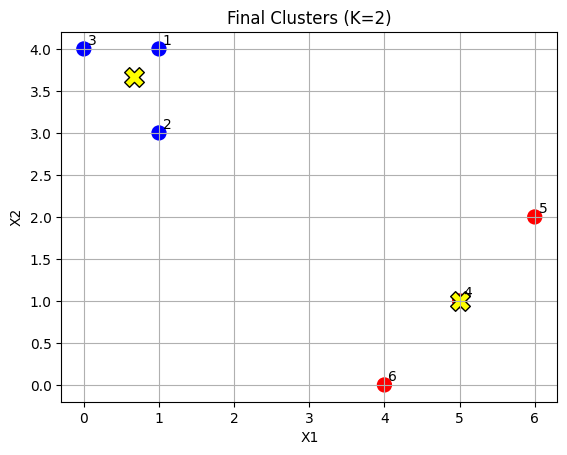

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='bwr', s=100)
plt.scatter(centroids[:, 0], centroids[:, 1], c='yellow', marker='X', s=200, edgecolor='black')
for i, (x1, x2) in enumerate(X, start=1):
    plt.text(x1 + 0.05, x2 + 0.05, str(i))
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Final Clusters (K=2)")
plt.grid(True)
plt.show()


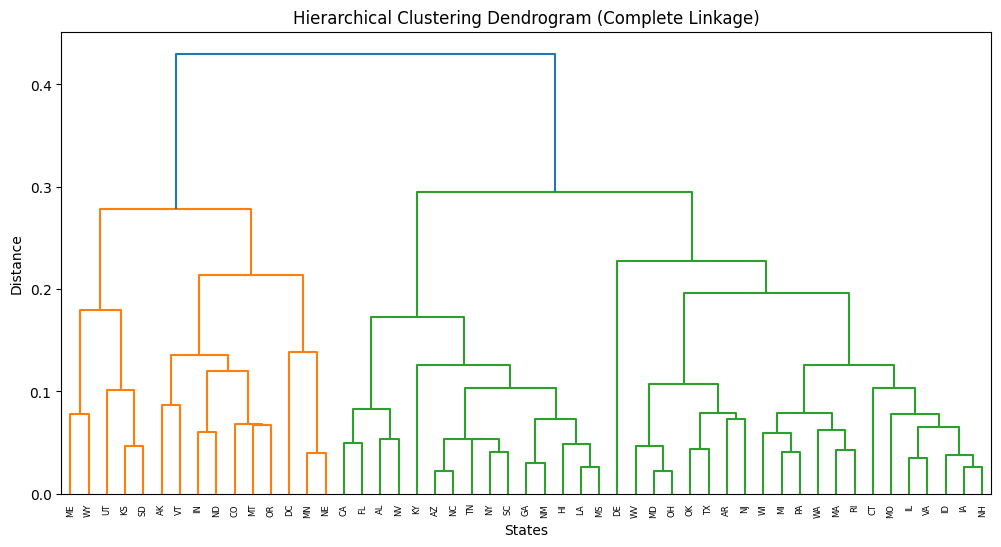

In [21]:
from scipy.cluster.hierarchy import linkage, dendrogram

X = data.iloc[:, 1:].values  # assumes first column is state names

# Hierarchical clustering
Z = linkage(X, method='complete', metric='euclidean')

# Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=data.iloc[:, 0].values, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Complete Linkage)")
plt.xlabel("States")
plt.ylabel("Distance")
plt.show()

In [22]:
from scipy.cluster.hierarchy import fcluster

clusters_3 = fcluster(Z, t=3, criterion='maxclust')
clustered_states_3 = pd.DataFrame({'State': data.iloc[:,0], 'Cluster': clusters_3})
print("States in 3 clusters:")
print(clustered_states_3.sort_values('Cluster'))


States in 3 clusters:
   State  Cluster
1     AK        1
5     CO        1
14    IN        1
8     DC        1
27    NE        1
23    MN        1
19    ME        1
16    KS        1
26    MT        1
44    UT        1
50    WY        1
45    VT        1
41    SD        1
34    ND        1
37    OR        1
11    HI        2
31    NM        2
28    NV        2
18    LA        2
17    KY        2
4     CA        2
10    GA        2
32    NY        2
42    TN        2
40    SC        2
33    NC        2
24    MS        2
9     FL        2
2     AZ        2
0     AL        2
6     CT        3
3     AR        3
30    NJ        3
29    NH        3
25    MO        3
22    MI        3
21    MA        3
20    MD        3
13    IL        3
15    IA        3
7     DE        3
12    ID        3
36    OK        3
38    PA        3
39    RI        3
43    TX        3
46    VA        3
35    OH        3
47    WA        3
48    WV        3
49    WI        3


In [23]:
clusters_4 = fcluster(Z, t=4, criterion='maxclust')
clustered_states_4 = pd.DataFrame({'State': data.iloc[:,0], 'Cluster': clusters_4})
print("States in 4 clusters:")
print(clustered_states_4.sort_values('Cluster'))


States in 4 clusters:
   State  Cluster
19    ME        1
16    KS        1
41    SD        1
44    UT        1
50    WY        1
27    NE        2
1     AK        2
5     CO        2
26    MT        2
23    MN        2
37    OR        2
45    VT        2
34    ND        2
8     DC        2
14    IN        2
11    HI        3
31    NM        3
28    NV        3
18    LA        3
17    KY        3
4     CA        3
10    GA        3
32    NY        3
42    TN        3
40    SC        3
33    NC        3
24    MS        3
9     FL        3
2     AZ        3
0     AL        3
6     CT        4
3     AR        4
30    NJ        4
29    NH        4
25    MO        4
22    MI        4
21    MA        4
20    MD        4
13    IL        4
15    IA        4
7     DE        4
12    ID        4
36    OK        4
38    PA        4
39    RI        4
43    TX        4
46    VA        4
35    OH        4
47    WA        4
48    WV        4
49    WI        4


In [24]:
from sklearn.cluster import KMeans

kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans3_labels = kmeans3.fit_predict(X)

kmeans3_df = pd.DataFrame({'State': data.iloc[:,0], 'Cluster': kmeans3_labels})
print("K-means (K=3) cluster assignments:")
print(kmeans3_df.sort_values('Cluster'))


K-means (K=3) cluster assignments:
   State  Cluster
6     CT        0
7     DE        0
14    IN        0
15    IA        0
12    ID        0
13    IL        0
21    MA        0
16    KS        0
25    MO        0
22    MI        0
29    NH        0
44    UT        0
41    SD        0
47    WA        0
39    RI        0
38    PA        0
46    VA        0
49    WI        0
30    NJ        1
9     FL        1
4     CA        1
18    LA        1
20    MD        1
17    KY        1
24    MS        1
31    NM        1
28    NV        1
3     AR        1
10    GA        1
11    HI        1
0     AL        1
2     AZ        1
43    TX        1
42    TN        1
35    OH        1
36    OK        1
40    SC        1
33    NC        1
48    WV        1
32    NY        1
26    MT        2
27    NE        2
19    ME        2
23    MN        2
5     CO        2
1     AK        2
8     DC        2
34    ND        2
45    VT        2
37    OR        2
50    WY        2


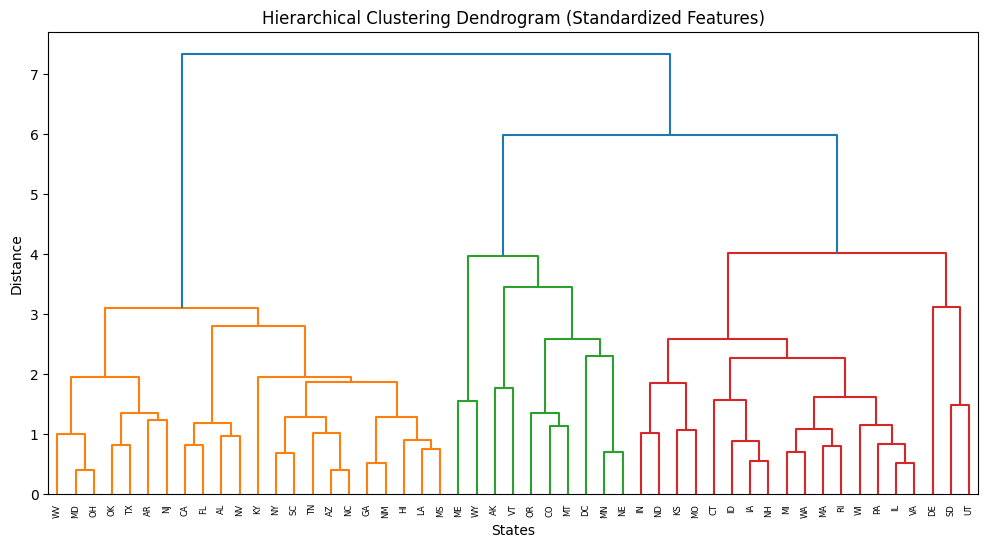

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Z_scaled = linkage(X_scaled, method='complete', metric='euclidean')

plt.figure(figsize=(12, 6))
dendrogram(Z_scaled, labels=data.iloc[:, 0].values, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Standardized Features)")
plt.xlabel("States")
plt.ylabel("Distance")
plt.show()


In [26]:
clusters_scaled_3 = fcluster(Z_scaled, t=3, criterion='maxclust')
clustered_scaled_3 = pd.DataFrame({'State': data.iloc[:,0], 'Cluster': clusters_scaled_3})
print("States in 3 clusters (standardized features):")
print(clustered_scaled_3.sort_values('Cluster'))


States in 3 clusters (standardized features):
   State  Cluster
0     AL        1
2     AZ        1
3     AR        1
4     CA        1
10    GA        1
11    HI        1
9     FL        1
17    KY        1
24    MS        1
31    NM        1
30    NJ        1
28    NV        1
18    LA        1
20    MD        1
33    NC        1
32    NY        1
48    WV        1
40    SC        1
43    TX        1
42    TN        1
36    OK        1
35    OH        1
37    OR        2
45    VT        2
26    MT        2
27    NE        2
23    MN        2
19    ME        2
8     DC        2
50    WY        2
5     CO        2
1     AK        2
29    NH        3
25    MO        3
21    MA        3
22    MI        3
16    KS        3
13    IL        3
14    IN        3
15    IA        3
12    ID        3
6     CT        3
7     DE        3
39    RI        3
41    SD        3
44    UT        3
34    ND        3
38    PA        3
47    WA        3
46    VA        3
49    WI        3


In [27]:
kmeans_scaled = KMeans(n_clusters=3, random_state=42)
kmeans_scaled_labels = kmeans_scaled.fit_predict(X_scaled)

kmeans_scaled_df = pd.DataFrame({'State': data.iloc[:,0], 'Cluster': kmeans_scaled_labels})
print("K-means (K=3) cluster assignments (z-scores):")
print(kmeans_scaled_df.sort_values('Cluster'))


K-means (K=3) cluster assignments (z-scores):
   State  Cluster
8     DC        0
19    ME        0
50    WY        0
45    VT        0
11    HI        1
10    GA        1
3     AR        1
0     AL        1
24    MS        1
31    NM        1
30    NJ        1
28    NV        1
20    MD        1
18    LA        1
9     FL        1
2     AZ        1
33    NC        1
40    SC        1
43    TX        1
42    TN        1
32    NY        1
35    OH        1
36    OK        1
48    WV        1
17    KY        1
4     CA        1
15    IA        2
14    IN        2
1     AK        2
5     CO        2
13    IL        2
12    ID        2
29    NH        2
25    MO        2
26    MT        2
27    NE        2
16    KS        2
21    MA        2
22    MI        2
23    MN        2
7     DE        2
6     CT        2
39    RI        2
38    PA        2
41    SD        2
44    UT        2
37    OR        2
34    ND        2
47    WA        2
46    VA        2
49    WI        2


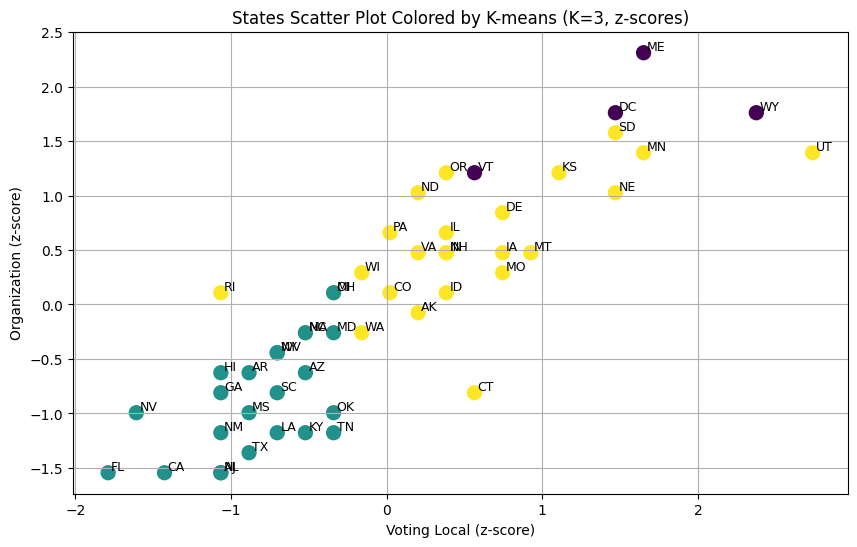

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_scaled_labels, cmap='viridis', s=100)

for i, state in enumerate(data.iloc[:, 0]):
    plt.text(X_scaled[i, 0]+0.02, X_scaled[i, 1]+0.02, state, fontsize=9)

plt.xlabel("Voting Local (z-score)")
plt.ylabel("Organization (z-score)")
plt.title("States Scatter Plot Colored by K-means (K=3, z-scores)")
plt.grid(True)
plt.show()
